In [176]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import sklearn
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, Normalizer, StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone
import sklearn_pandas
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score,train_test_split
from scipy import stats
from sklearn.linear_model import LinearRegression
from scipy.special import boxcox1p
import csv

import warnings
warnings.filterwarnings('ignore')

import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress ConvergenceWarning warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [177]:
# kaggle train data
data_df = pd.read_csv("train.csv")
# kaggle test data
test_df = pd.read_csv("test.csv")

In [178]:
all_data = pd.concat((data_df.loc[:,:], test_df.loc[:, :]))
all_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [179]:
# Basic summary:
data_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<Axes: xlabel='SalePrice', ylabel='Density'>

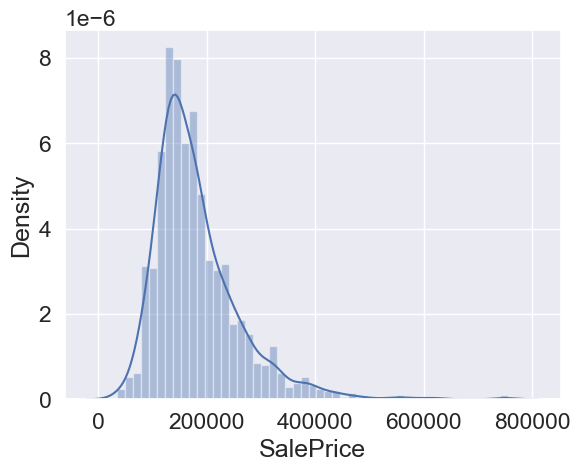

In [180]:
# The Density Plot of SalePrice
sns.distplot(data_df['SalePrice'])

In [181]:
data_df['SalePrice'].skew()

1.8828757597682129

In [182]:
data_df["SalePrice"] = np.log1p(data_df["SalePrice"])

Text(0.5, 1.0, 'Density plot of SalePrice after Log Transformation')

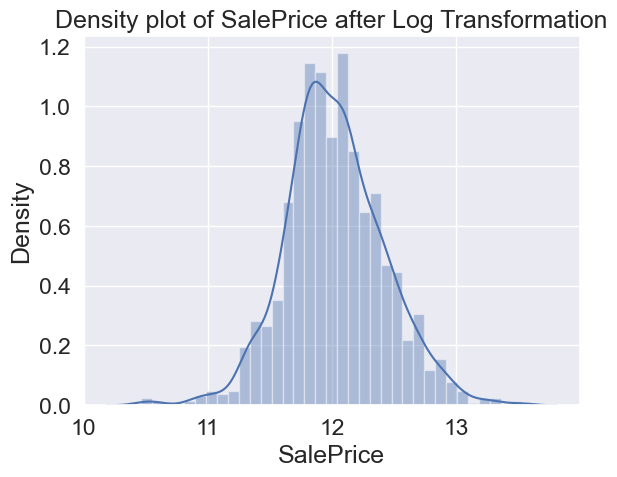

In [183]:
# SalePrice after Log-transformation
sns.distplot(data_df["SalePrice"])
plt.title("Density plot of SalePrice after Log Transformation")

In [184]:

y_train = data_df["SalePrice"]

### Columns with Nan values

At first, I am checking the fraction of Nan values in each column.

In [185]:
col_nan = data_df.isna().sum() / data_df.shape[0]


Text(0.5, 1.0, 'Features with the highest percentage of Nan values')

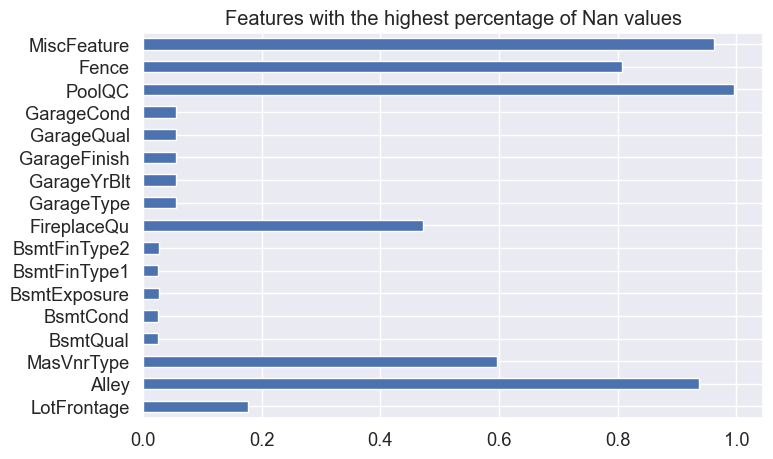

In [186]:

plt.figure(figsize=(8, 5))
sns.set(font_scale=1.2)
col_nan[col_nan > 0.01].plot(kind = "barh")
plt.title("Features with the highest percentage of Nan values")

### Removing Id column

In [187]:
# Dropping columns for both train and test dataset
data_df = data_df.drop("Id", axis=1)
test_df = test_df.drop("Id", axis=1)

### Removing columns that contain the same value in 100%

According to basic statistics provided on Kaggle competiton website, the columns Street and Utilities contain only one value "Pave" and "AllPub" respectively.

In [188]:
data_df = data_df.drop(["Street", "Utilities"], axis=1)
test_df = test_df.drop(["Street", "Utilities"], axis=1)

### Removing outliers

Removing outliers is important step in data analysis. However, while removing outliers in ML we should be careful, because we do not know if there are not any outliers in test set.

I used two techniques: more and less rigorous for this data.

The first one was Z-score method. Z-scores are expressed in terms of standard deviations from their means. As a result, these z-scores have a distribution with a mean of 0 and a standard deviation of 1.
I set threshold = 3 to identify outliers.


In [189]:
def remove_outliers(dataset, threshold, columns=None, removed = False):
    """ 
    Z-score method.
    Function returns a dataframe without rows labeled as 'outliers' according to the given threshold.  
    ---------------
    If columns = None, transform all numerical columns.
    If removed = True, return also dataframe with removed rows.
    """
    if columns==None:
        numerics = ['int64','float64']
        columns = dataset.select_dtypes(include=numerics).columns
    
    tmp = dataset.copy()
    z = np.abs(stats.zscore(tmp[columns]))
    outliers = [row.any() for row in (z > threshold)]  
    outliers_idxs = tmp.index[outliers].tolist()
    print("Number of removed rows = {}".format(len(outliers_idxs)))
    if removed: return dataset.drop(outliers_idxs), tmp.loc[outliers]
    else: return dataset.drop(outliers_idxs)

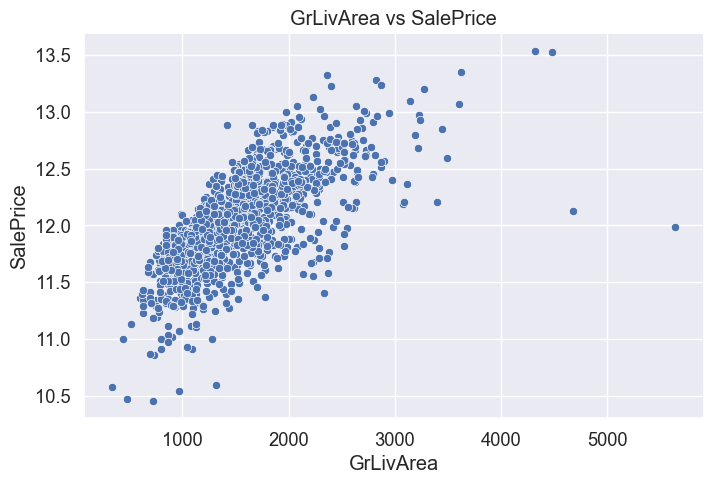

In [190]:
plt.figure(figsize=(8, 5))
sns.set(font_scale=1.2)
sns.scatterplot(x="GrLivArea", y="SalePrice", data=data_df)
plt.title("GrLivArea vs SalePrice")
plt.show()

In [191]:
# I decided to remove those records where 'GrLivArea' is more than 4500. We can see on plot that they have a vey low price.
clear_data = data_df.drop(data_df[(data_df['GrLivArea']>4500)].index)

# Concatenate all data together - both train and test
train_ = clear_data.drop(['SalePrice'], axis=1)
all_data = pd.concat([data_df, test_df]).reset_index(drop=True)


#### GarageYrBlt feature

I checked if there are records that YearBuilt or GarageYrBlt have further year than 2017.

In [192]:
print("Is there YearBuilt more than 2017 ? : ", all_data[all_data.YearBuilt > 2017].count()[0] != 0)
print("Is there GarageYrBlt more than 2017 ? : ", all_data[all_data.GarageYrBlt > 2017].count()[0] != 0)

Is there YearBuilt more than 2017 ? :  False
Is there GarageYrBlt more than 2017 ? :  True


In [193]:
all_data[all_data.GarageYrBlt > 2017].GarageYrBlt #It seems like it is a typo


2592    2207.0
Name: GarageYrBlt, dtype: float64

In [194]:
all_data.loc[2590, 'GarageYrBlt'] = 2007

#### LotFrontage feature

LotFrontage is a linear feet of street connected to property. I think it is a high probability that these values are similar to houses in the same Neighborhood. I check some statistics for them.

In [195]:
neigh_lot_frontage = all_data.groupby('Neighborhood')['LotFrontage'].agg(["mean", "median"])
neigh_lot_frontage['avg_mean_median'] = (neigh_lot_frontage['mean'] + neigh_lot_frontage['median'] )/ 2
neigh_lot_frontage

,mean,median,avg_mean_median
Neighborhood,,,
Blmngtn,46.900000,43.0,44.950000
Blueste,27.300000,24.0,25.650000
BrDale,21.500000,21.0,21.250000
BrkSide,55.789474,51.0,53.394737
ClearCr,88.150000,80.5,84.325000
CollgCr,71.336364,70.0,70.668182
Crawfor,69.951807,70.0,69.975904
Edwards,66.910112,65.0,65.955056
Gilbert,74.207207,64.0,69.103604


In [196]:
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

### Transformation of some numerical variables that are actually categorical.

In [197]:
def convert_to_string(df, columns):
    df[columns] = df[columns].astype(str)
    return df

num_to_categ_features = ['MSSubClass', 'OverallCond']#, 'YrSold', 'MoSold']

all_data = convert_to_string(all_data, columns = num_to_categ_features)

### Replacing missing values in the rest of numerical columns

For the other numerical data I will also estimate them according to their statistics and for that I will use SimpleImputer object from sklearn library. For columns: BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, BsmtFullBath and BsmtHalfBath , MasVnrArea I will fill Nan values with constant = 0 and for the rest with median.

In [198]:
num_features = all_data.select_dtypes(include=['int64','float64']).columns
num_features_to_constant = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', "MasVnrArea"] 
num_features_to_median = [feature for feature in num_features if feature not in num_features_to_constant + ["SalePrice"]]

# Generating numerical features as input to DataFrameMapper.  
numeric_features_median = sklearn_pandas.gen_features(columns=[num_features_to_median], 
                                               classes=[{'class': SimpleImputer, 
                                                         'strategy': 'median', 
                                                         'missing_values' : np.nan}])

numeric_features_zero = sklearn_pandas.gen_features(columns=[num_features_to_constant], 
                                               classes=[{'class': SimpleImputer, 
                                                         'strategy': 'constant',
                                                         'fill_value' : 0, 
                                                         'missing_values' : np.nan}])

missing_val_imputer = sklearn_pandas.DataFrameMapper(numeric_features_median + numeric_features_zero)

# Fitting
imputed_median = missing_val_imputer.fit(all_data)

# Transformation
imputed_features = imputed_median.transform(all_data)

# Putting into dataframe
imputed_df = pd.DataFrame(imputed_features, index=all_data.index, columns=num_features_to_median + num_features_to_constant)


### Categorical to numeral

There is a lot of categorical features in data, so the next step is to transform them into numerical values.

In [199]:
# Selecting category features
cat_feats = all_data.select_dtypes(include=['object']).columns

none_conversion = [("MasVnrType","None"),
                  ("BsmtQual","NA"), 
                  ("Electrical", "SBrkr"),
                  ("BsmtCond","TA"),
                  ("BsmtExposure","No"),
                  ("BsmtFinType1","No"),
                  ("BsmtFinType2","No"),
                  ("CentralAir","N"),
                  ("Condition1","Norm"), 
                  ("Condition2","Norm"),
                  ("ExterCond","TA"),
                  ("ExterQual","TA"), 
                  ("FireplaceQu","NA"),
                  ("Functional","Typ"),
                  ("GarageType","No"), 
                  ("GarageFinish","No"), 
                  ("GarageQual","NA"), 
                  ("GarageCond","NA"), 
                  ("HeatingQC","TA"), 
                  ("KitchenQual","TA"), 
                  ("Functional","Typ"), 
                  ("GarageType","No"), 
                  ("GarageFinish","No"), 
                  ("GarageQual","No"), 
                  ("GarageCond","No"), 
                  ("HeatingQC","TA"), 
                  ("KitchenQual","TA"),
                  ("MSZoning", "None"),
                  ("Exterior1st", "VinylSd"), 
                  ("Exterior2nd", "VinylSd"), 
                  ("SaleType", "WD")]

I implemented the none_transform function which converts missing categorical values into specific strings from the none_conversion dictionary.

In [200]:
def none_transform(df, conversion_list):
    ''' Function that converts missing categorical values 
    into specific strings according to "conversion_list" 
    
    Returns the dataframe after transformation.
    '''
    for col, new_str in conversion_list:
        df.loc[:, col] = df.loc[:, col].fillna(new_str)
    return df

In [201]:

# Applying the "none_transform" function 
all_data = none_transform(all_data, none_conversion)

In [202]:
len(all_data.columns)

78

### Transformation of skewed features

As for linear models preferable are normally distributed data, I am transforming the skewed features to make them more normally distributed.

In [203]:
# collecting the numeric features without considering SalePrice
numeric_features = [feat for feat in num_features if feat not in ['SalePrice']] 

# selecting columns with skew more than 0.5
skewed_features = all_data[num_features].apply(lambda x: x.dropna().skew())
skewed_features = skewed_features[skewed_features > 0.5].index
print("\nHighly skewed features: \n\n{}".format(skewed_features.tolist()))


Highly skewed features: 

['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']


A Box Cox transformation is a way to transform non-normal dependent variables into a normal shape.

In [204]:

#The “optimal lambda” is the one that results in the best approximation of a normal distribution curve. I selected lambda= 0.15.

lambda_ = 0.15
for feature in skewed_features:
    all_data[feature] = boxcox1p(all_data[feature], lambda_)

## Categorical into Numerical

As some categorical features (i.e. KitchenQual, GarageQual) can be transformed into the numerical values with some order, I also implemented a new encoder for them.

In [205]:
class OrderedLabelTransformer(BaseEstimator, TransformerMixin):
    orderDict = {"NA" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}
    
    @staticmethod
    def get_dict(X):
        FirstDict = {"Po" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4}
        SecondDict = {"NA" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}
        ThirdDict = {"NA" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4}
        for d in [FirstDict, SecondDict, ThirdDict]:
            if set(X) == set(d): 
                return d
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        def get_label(t):
            return self.orderDict[t]
        return np.array([get_label(n) for n in X])

In [206]:
class NeighborhoodTransformer(BaseEstimator, TransformerMixin):
    neighborhoodsmap = {'StoneBr' : 2, 'NridgHt' : 2, 'NoRidge': 2, 
                        'MeadowV' : 0, 'IDOTRR' : 0, 'BrDale' : 0 ,
                        'CollgCr': 1, 'Veenker' : 1, 'Crawfor' : 1,
                        'Mitchel' : 1, 'Somerst' : 1, 'NWAmes' : 1,
                        'OldTown' : 1, 'BrkSide' : 1, 'Sawyer' : 1, 
                        'NAmes' : 1, 'SawyerW' : 1, 'Edwards' : 1,
                        'Timber' : 1, 'Gilbert' : 1, 'ClearCr' : 1,
                        'NPkVill' : 1, 'Blmngtn' : 1, 'SWISU' : 1,
                        'Blueste': 1}

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        def get_label(t):
            return self.neighborhoodsmap[t]
        return np.array([get_label(n) for [n] in X])

As I implemented previously specific transformers for categorical data, I will run the whole pipeline for them.

In [207]:
# Generating features:
order_feats = ["ExterQual", "ExterCond", "HeatingQC", "KitchenQual", "BsmtQual", 
               "BsmtCond", "FireplaceQu", "GarageQual", "GarageCond"]

original_features_df = all_data[order_feats + ['Neighborhood']] # we need to save original values for one-hot encoding

order_features = sklearn_pandas.gen_features(order_feats, [OrderedLabelTransformer])
neighb_features = [(['Neighborhood'], [NeighborhoodTransformer()])]

# Pipeline
label_encoder = sklearn_pandas.DataFrameMapper(neighb_features + order_features)

# The list with order of column names
cols = ["Neighborhood"] + order_feats

# Transformation both train and test set
transformed_feats = label_encoder.fit_transform(all_data)

# Putting transformed features into dataframe
transformed_df = pd.DataFrame(transformed_feats, index=all_data.index, columns=cols)


In [208]:
original_features_df.shape


(2919, 10)

In [209]:
# feature without any transformation till now
rest_features = set(pd.concat([imputed_df, original_features_df],axis=1).columns).symmetric_difference(set(all_data.columns))
rest_features_df = all_data[list(rest_features)]

In [210]:
all_data = pd.concat([imputed_df, original_features_df, rest_features_df],axis=1)
all_data.shape

(2919, 78)

## Feature Engineering
Creating new features

These features seem to be useful for house price prediction. As they are not contained in kaggle dataset I decided to create them from other informations.

"TotalSqrtFeet" - Total Live Area
"TotalBaths" - Total Area for Bathrooms

In [211]:
# Total Squere Feet for house
all_data["TotalSqrtFeet"] = all_data["GrLivArea"] + all_data["TotalBsmtSF"]
# test_df["TotalSqrtFeet"] = test_df["GrLivArea"] + test_df["TotalBsmtSF"]

# Total number of bathrooms
all_data["TotalBaths"] = all_data["BsmtFullBath"] + (all_data["BsmtHalfBath"]  * .5) + all_data["FullBath"] + (all_data["HalfBath"]* .5)
# test_df["TotalBaths"] = test_df["BsmtFullBath"] + (test_df["BsmtHalfBath"]  * .5) + test_df["FullBath"] + (test_df["HalfBath"]* .5)

# If the house has a garage
all_data['Isgarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

# If the house has a fireplace
all_data['Isfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

# If the house has a pool
all_data['Ispool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

# If the house has second floor
all_data['Issecondfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)

# If the house has Open Porch
all_data['IsOpenPorch'] = all_data['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)

# If the house has Wood Deck
all_data['IsWoodDeck'] = all_data['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)

#### One Hot encoding

In [212]:
all_data = all_data.drop(["SalePrice"], axis = 1)

hot_one_features = pd.get_dummies(all_data).reset_index(drop=True)
hot_one_features.shape


all_data = pd.concat([transformed_df, hot_one_features],axis=1)

## Splitting into train/test


In [213]:
train_preprocessed = all_data.iloc[:len(data_df),:]
test_preprocessed = all_data.iloc[len(train_preprocessed):,:]
print(len(test_preprocessed) == len(test_df))

True


## Model Engineering 

In [214]:
X_train = train_preprocessed


In [215]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

from sklearn.linear_model import ElasticNet, Lasso, ElasticNetCV
from sklearn.ensemble import  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.base import RegressorMixin
import lightgbm as lgb

In [216]:
print('Environment specification:\n')
for mod in sklearn, xgb, lgb:
    print(mod.__name__, mod.__version__)

Environment specification:

sklearn 1.5.0
xgboost 2.0.3
lightgbm 4.4.0


In [217]:
def rmse(model):
    n_folds=5
    kfold = KFold(n_folds, random_state=42, shuffle=True).get_n_splits(X_train)
    rmse_score = np.sqrt(-cross_val_score(model, X_train, y_train, scoring = "neg_mean_squared_error", cv = kfold, verbose = 0, n_jobs=-1))
    return(np.mean(rmse_score))

In [218]:
lr_model = make_pipeline(RobustScaler(), LinearRegression()) #TODO: why Robust Scaler?

lr_model.fit(X_train, y_train)
y_train_pred = lr_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for Linear Regression: {:.3f}".format(rmse(lr_model)))


Mean Squared Error = 0.00858436
RMSE score for Linear Regression: 26481.146


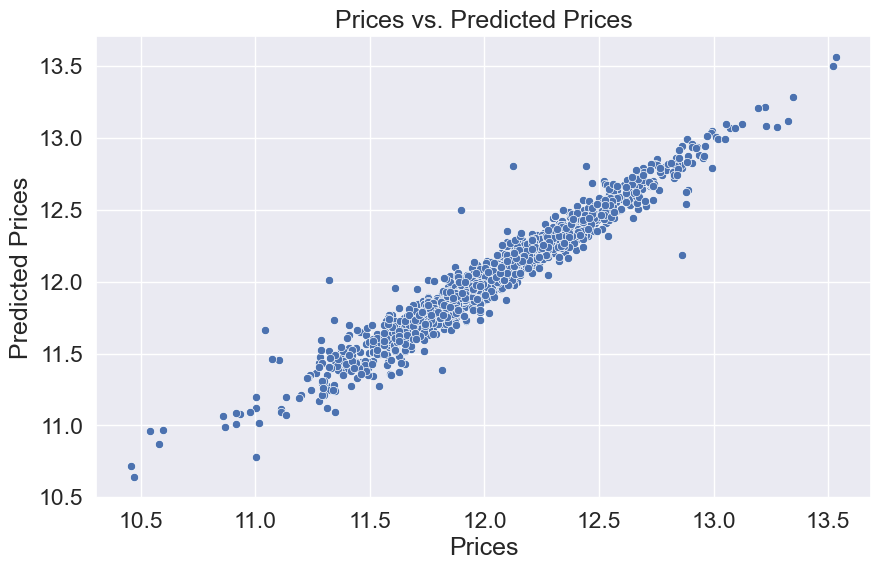

In [219]:
sns.set(font_scale=1.5)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_train, y=y_train_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted Prices")
plt.title("Prices vs. Predicted Prices")
plt.show()

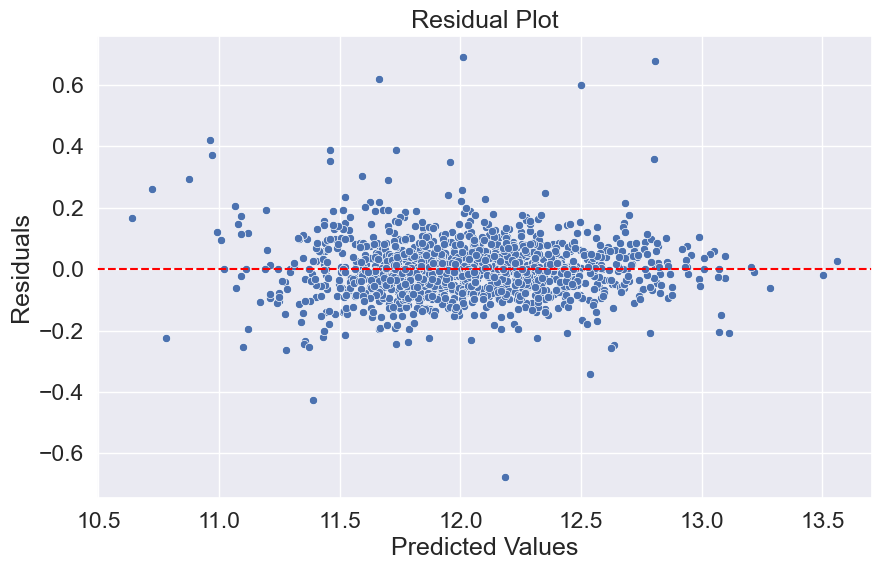

In [220]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_train_pred, y=(y_train_pred - y_train))
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.axhline(0, color='red', linestyle='--')
plt.show()

## Lasso Model

In [221]:
lasso_model = make_pipeline(RobustScaler(), 
                         LassoCV(alphas = [0.0004, 0.0005, 0.0006],
                                 random_state = 0,
                                 cv = 10))

lasso_model.fit(X_train, y_train)

y_train_pred = lasso_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

# print("Best alpha : {}", lasso_model.alpha_)
print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for LASSO: {:.3f}".format(rmse(lasso_model)))

Mean Squared Error = 0.01197439
RMSE score for LASSO: 0.135


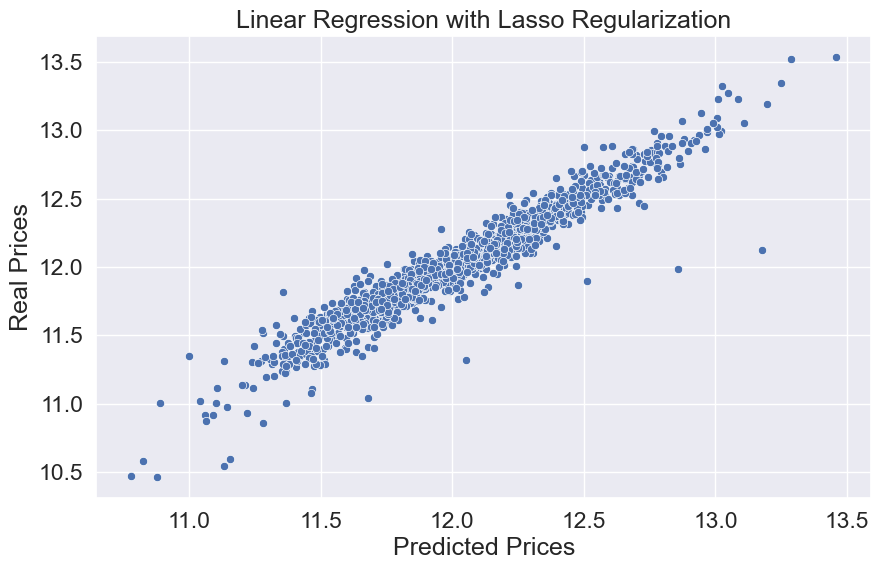

In [222]:

# Plotting predictions
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_train_pred, y=y_train)
plt.title("Linear Regression with Lasso Regularization")
plt.xlabel("Predicted Prices")
plt.ylabel("Real Prices")
plt.show()

## Gradient Boosting

In [223]:
gbr = GradientBoostingRegressor(random_state=0)
param_grid = {'n_estimators': [2500],
              'max_features': [13],
              'max_depth': [5],
              'learning_rate': [0.05],
              'subsample': [0.8],
             'random_state' : [5]}
                              
gb_model = GridSearchCV(estimator=gbr, param_grid=param_grid, n_jobs=1, cv=5)
gb_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=0),
             n_jobs=1,
             param_grid={'learning_rate': [0.05], 'max_depth': [5],
                         'max_features': [13], 'n_estimators': [2500],
                         'random_state': [5], 'subsample': [0.8]})

In [224]:
y_train_pred = gb_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)
print('Best Parameters: {}'.format(gb_model.best_params_))
print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for GB: {:.3f}".format(rmse(gb_model)))

Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'max_features': 13, 'n_estimators': 2500, 'random_state': 5, 'subsample': 0.8}
Mean Squared Error = 0.00000935
RMSE score for GB: 0.123


## XGB Regressor

In [225]:
xgbreg = xgb.XGBRegressor(seed=0)
param_grid2 = {'n_estimators': [2000], 
              'learning_rate': [0.05],
              'max_depth': [3, 7],
              'subsample': [0.8],
              'colsample_bytree': [0.45, 0.75]}
    
xgb_model = GridSearchCV(estimator=xgbreg, param_grid=param_grid2, n_jobs=1, cv=10)
xgb_model.fit(X_train, y_train)

y_train_pred = xgb_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

print('\n\nBest Parameters: {}'.format(xgb_model.best_params_))
print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for XGB: {:.3f}".format(rmse(xgb_model)))



Best Parameters: {'colsample_bytree': 0.45, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 2000, 'subsample': 0.8}
Mean Squared Error = 0.00049944
RMSE score for XGB: 0.120


## ElasticNet

In [226]:
en_model = ElasticNetCV(alphas = [0.0001, 0.0003, 0.0004, 0.0006], 
                        l1_ratio = [.9, .92], 
                        random_state = 0,
                        cv=10)

en_model.fit(X_train, y_train)

y_train_pred = en_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for ElasticNet: {:.3f}".format(rmse(en_model)))

Mean Squared Error = 0.01171991


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3192730772480683, tolerance: 0.016191364933028217
  model = cd_fast.enet_coordinate_descent_gram(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.029079379147528, tolerance: 0.017000683356241546
  model = cd_fast.enet_coordinate_descent_gram(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7969465888754943, tolerance: 0.017000683356241546
  model = cd_fast.en

RMSE score for ElasticNet: 0.136


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.540e+00, tolerance: 1.901e-02
  model = cd_fast.enet_coordinate_descent(


## LightGBM

In [227]:
lgb_model = lgb.LGBMRegressor(objective='regression', num_leaves=5,
                              learning_rate=0.05, n_estimators=800,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

lgb_model.fit(X_train, y_train)

y_train_pred = lgb_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for LGBMRegressor: {:.4f}".format(rmse(lgb_model)))

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Cu

## BaggingRegressor

In [228]:
from sklearn.ensemble import BaggingRegressor

model2 = sklearn.ensemble.BaggingRegressor(estimator = lasso_model, n_estimators = 50, 
                                           max_samples = 30, max_features = 200, verbose = 3, n_jobs = 3)
model2.fit(X_train, y_train)

y_train_pred = model2.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

print("Mean Squared Error = {:.8f}".format(MSE_train))

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Building estimator 1 of 17 for this parallel run (total 50)...Building estimator 1 of 17 for this parallel run (total 50)...

Building estimator 1 of 16 for this parallel run (total 50)...
Building estimator 2 of 16 for this parallel run (total 50)...
Building estimator 2 of 17 for this parallel run (total 50)...
Building estimator 2 of 17 for this parallel run (total 50)...
Building estimator 3 of 16 for this parallel run (total 50)...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.984e-03, tolerance: 6.587e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.888e-03, tolerance: 6.587e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Building estimator 3 of 17 for this parallel run (total 50)...
Building estimator 4 of 16 for this parallel run (total 50)...
Building estimator 3 of 17 for this parallel run (total 50)...
Building estimator 4 of 17 for this parallel run (total 50)...
Building estimator 4 of 17 for this parallel run (total 50)...
Building estimator 5 of 16 for this parallel run (total 50)...
Building estimator 5 of 17 for this parallel run (total 50)...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.559e-04, tolerance: 3.438e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.125e-02, tolerance: 2.723e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Building estimator 5 of 17 for this parallel run (total 50)...
Building estimator 6 of 17 for this parallel run (total 50)...
Building estimator 6 of 16 for this parallel run (total 50)...
Building estimator 6 of 17 for this parallel run (total 50)...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.094e-02, tolerance: 2.887e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.299e-02, tolerance: 4.492e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Building estimator 7 of 17 for this parallel run (total 50)...
Building estimator 7 of 16 for this parallel run (total 50)...
Building estimator 7 of 17 for this parallel run (total 50)...
Building estimator 8 of 16 for this parallel run (total 50)...
Building estimator 8 of 17 for this parallel run (total 50)...
Building estimator 8 of 17 for this parallel run (total 50)...
Building estimator 9 of 16 for this parallel run (total 50)...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.358e-02, tolerance: 5.159e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.390e-02, tolerance: 2.931e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Building estimator 9 of 17 for this parallel run (total 50)...
Building estimator 9 of 17 for this parallel run (total 50)...
Building estimator 10 of 16 for this parallel run (total 50)...
Building estimator 10 of 17 for this parallel run (total 50)...
Building estimator 10 of 17 for this parallel run (total 50)...
Building estimator 11 of 16 for this parallel run (total 50)...
Building estimator 11 of 17 for this parallel run (total 50)...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.252e-03, tolerance: 2.750e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.054e-03, tolerance: 5.012e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Building estimator 11 of 17 for this parallel run (total 50)...
Building estimator 12 of 17 for this parallel run (total 50)...
Building estimator 12 of 16 for this parallel run (total 50)...
Building estimator 12 of 17 for this parallel run (total 50)...
Building estimator 13 of 17 for this parallel run (total 50)...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.681e-03, tolerance: 3.186e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.158e-02, tolerance: 2.124e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Building estimator 13 of 16 for this parallel run (total 50)...
Building estimator 13 of 17 for this parallel run (total 50)...
Building estimator 14 of 17 for this parallel run (total 50)...
Building estimator 14 of 17 for this parallel run (total 50)...
Building estimator 14 of 16 for this parallel run (total 50)...
Building estimator 15 of 17 for this parallel run (total 50)...
Building estimator 15 of 17 for this parallel run (total 50)...
Building estimator 15 of 16 for this parallel run (total 50)...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.220e-03, tolerance: 4.469e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.574e-03, tolerance: 4.629e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Building estimator 16 of 17 for this parallel run (total 50)...
Building estimator 16 of 17 for this parallel run (total 50)...
Building estimator 16 of 16 for this parallel run (total 50)...
Building estimator 17 of 17 for this parallel run (total 50)...
Building estimator 17 of 17 for this parallel run (total 50)...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.103e-03, tolerance: 5.944e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.738e-03, tolerance: 7.105e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Mean Squared Error = 0.04086133


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished


In [229]:
print("RMSE score for BaggingRegressor: {:.4f}".format(rmse(model2)))

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.741e-03, tolerance: 6.368e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the num

Building estimator 1 of 17 for this parallel run (total 50)...
Building estimator 1 of 17 for this parallel run (total 50)...
Building estimator 1 of 17 for this parallel run (total 50)...
Building estimator 1 of 17 for this parallel run (total 50)...
Building estimator 1 of 17 for this parallel run (total 50)...
Building estimator 1 of 16 for this parallel run (total 50)...Building estimator 1 of 17 for this parallel run (total 50)...
Building estimator 1 of 17 for this parallel run (total 50)...
Building estimator 1 of 17 for this parallel run (total 50)...

Building estimator 1 of 16 for this parallel run (total 50)...
Building estimator 1 of 16 for this parallel run (total 50)...
Building estimator 1 of 16 for this parallel run (total 50)...
Building estimator 1 of 17 for this parallel run (total 50)...Building estimator 1 of 17 for this parallel run (total 50)...

Building estimator 1 of 16 for this parallel run (total 50)...
Building estimator 2 of 17 for this parallel run (total

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.122e-03, tolerance: 6.380e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.397e-03, tolerance: 3.212e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Building estimator 2 of 17 for this parallel run (total 50)...
Building estimator 2 of 17 for this parallel run (total 50)...
Building estimator 2 of 17 for this parallel run (total 50)...
Building estimator 2 of 17 for this parallel run (total 50)...
Building estimator 2 of 16 for this parallel run (total 50)...
Building estimator 2 of 17 for this parallel run (total 50)...
Building estimator 2 of 17 for this parallel run (total 50)...
Building estimator 2 of 16 for this parallel run (total 50)...
Building estimator 2 of 17 for this parallel run (total 50)...
Building estimator 2 of 17 for this parallel run (total 50)...
Building estimator 2 of 17 for this parallel run (total 50)...
Building estimator 2 of 16 for this parallel run (total 50)...
Building estimator 2 of 16 for this parallel run (total 50)...
Building estimator 2 of 16 for this parallel run (total 50)...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.078e-02, tolerance: 4.101e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.659e-02, tolerance: 5.994e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Building estimator 3 of 17 for this parallel run (total 50)...
Building estimator 3 of 16 for this parallel run (total 50)...
Building estimator 3 of 17 for this parallel run (total 50)...
Building estimator 3 of 17 for this parallel run (total 50)...
Building estimator 3 of 16 for this parallel run (total 50)...
Building estimator 3 of 17 for this parallel run (total 50)...
Building estimator 3 of 17 for this parallel run (total 50)...
Building estimator 3 of 17 for this parallel run (total 50)...
Building estimator 3 of 17 for this parallel run (total 50)...
Building estimator 3 of 16 for this parallel run (total 50)...
Building estimator 3 of 17 for this parallel run (total 50)...
Building estimator 3 of 16 for this parallel run (total 50)...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.461e-03, tolerance: 3.193e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.897e-04, tolerance: 3.727e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Building estimator 3 of 16 for this parallel run (total 50)...
Building estimator 4 of 17 for this parallel run (total 50)...
Building estimator 3 of 17 for this parallel run (total 50)...
Building estimator 3 of 17 for this parallel run (total 50)...
Building estimator 4 of 16 for this parallel run (total 50)...
Building estimator 4 of 17 for this parallel run (total 50)...
Building estimator 4 of 17 for this parallel run (total 50)...
Building estimator 4 of 17 for this parallel run (total 50)...
Building estimator 4 of 16 for this parallel run (total 50)...
Building estimator 4 of 17 for this parallel run (total 50)...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.598e-03, tolerance: 4.043e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.255e-03, tolerance: 3.799e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Building estimator 4 of 17 for this parallel run (total 50)...
Building estimator 4 of 17 for this parallel run (total 50)...
Building estimator 4 of 16 for this parallel run (total 50)...
Building estimator 4 of 16 for this parallel run (total 50)...
Building estimator 5 of 17 for this parallel run (total 50)...
Building estimator 4 of 17 for this parallel run (total 50)...
Building estimator 5 of 16 for this parallel run (total 50)...
Building estimator 4 of 16 for this parallel run (total 50)...
Building estimator 5 of 17 for this parallel run (total 50)...
Building estimator 4 of 17 for this parallel run (total 50)...
Building estimator 4 of 17 for this parallel run (total 50)...
Building estimator 5 of 17 for this parallel run (total 50)...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.363e-02, tolerance: 5.740e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.795e-03, tolerance: 4.151e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Building estimator 5 of 17 for this parallel run (total 50)...
Building estimator 5 of 17 for this parallel run (total 50)...
Building estimator 6 of 16 for this parallel run (total 50)...
Building estimator 5 of 17 for this parallel run (total 50)...
Building estimator 5 of 17 for this parallel run (total 50)...
Building estimator 5 of 16 for this parallel run (total 50)...
Building estimator 5 of 16 for this parallel run (total 50)...
Building estimator 6 of 17 for this parallel run (total 50)...
Building estimator 5 of 17 for this parallel run (total 50)...
Building estimator 5 of 16 for this parallel run (total 50)...
Building estimator 5 of 17 for this parallel run (total 50)...
Building estimator 5 of 17 for this parallel run (total 50)...
Building estimator 6 of 17 for this parallel run (total 50)...
Building estimator 6 of 17 for this parallel run (total 50)...
Building estimator 6 of 17 for this parallel run (total 50)...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.079e-03, tolerance: 5.753e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.141e-02, tolerance: 7.545e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Building estimator 5 of 16 for this parallel run (total 50)...
Building estimator 6 of 17 for this parallel run (total 50)...
Building estimator 7 of 16 for this parallel run (total 50)...
Building estimator 6 of 17 for this parallel run (total 50)...
Building estimator 6 of 16 for this parallel run (total 50)...
Building estimator 7 of 17 for this parallel run (total 50)...
Building estimator 6 of 17 for this parallel run (total 50)...
Building estimator 6 of 17 for this parallel run (total 50)...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.208e-03, tolerance: 7.045e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.046e-03, tolerance: 3.284e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Building estimator 6 of 17 for this parallel run (total 50)...
Building estimator 6 of 16 for this parallel run (total 50)...
Building estimator 6 of 16 for this parallel run (total 50)...
Building estimator 6 of 16 for this parallel run (total 50)...
Building estimator 6 of 17 for this parallel run (total 50)...
Building estimator 7 of 17 for this parallel run (total 50)...
Building estimator 7 of 17 for this parallel run (total 50)...
Building estimator 7 of 16 for this parallel run (total 50)...
Building estimator 7 of 17 for this parallel run (total 50)...
Building estimator 7 of 17 for this parallel run (total 50)...
Building estimator 7 of 17 for this parallel run (total 50)...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.687e-03, tolerance: 8.916e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.643e-02, tolerance: 4.066e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Building estimator 8 of 17 for this parallel run (total 50)...
Building estimator 7 of 17 for this parallel run (total 50)...
Building estimator 7 of 16 for this parallel run (total 50)...
Building estimator 7 of 17 for this parallel run (total 50)...
Building estimator 8 of 17 for this parallel run (total 50)...
Building estimator 7 of 17 for this parallel run (total 50)...
Building estimator 8 of 17 for this parallel run (total 50)...
Building estimator 8 of 16 for this parallel run (total 50)...
Building estimator 7 of 16 for this parallel run (total 50)...
Building estimator 8 of 17 for this parallel run (total 50)...
Building estimator 8 of 17 for this parallel run (total 50)...
Building estimator 7 of 17 for this parallel run (total 50)...
Building estimator 8 of 17 for this parallel run (total 50)...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.116e-03, tolerance: 3.305e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.989e-03, tolerance: 4.498e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Building estimator 8 of 16 for this parallel run (total 50)...
Building estimator 7 of 16 for this parallel run (total 50)...
Building estimator 9 of 17 for this parallel run (total 50)...
Building estimator 9 of 17 for this parallel run (total 50)...
Building estimator 9 of 17 for this parallel run (total 50)...
Building estimator 8 of 17 for this parallel run (total 50)...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.065e-03, tolerance: 3.555e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.167e-03, tolerance: 3.214e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Building estimator 8 of 17 for this parallel run (total 50)...
Building estimator 8 of 17 for this parallel run (total 50)...
Building estimator 9 of 17 for this parallel run (total 50)...
Building estimator 9 of 16 for this parallel run (total 50)...
Building estimator 8 of 16 for this parallel run (total 50)...
Building estimator 9 of 17 for this parallel run (total 50)...
Building estimator 8 of 16 for this parallel run (total 50)...
Building estimator 8 of 17 for this parallel run (total 50)...
Building estimator 10 of 17 for this parallel run (total 50)...
Building estimator 8 of 16 for this parallel run (total 50)...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.262e-03, tolerance: 3.387e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.560e-03, tolerance: 2.833e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Building estimator 9 of 16 for this parallel run (total 50)...
Building estimator 10 of 17 for this parallel run (total 50)...
Building estimator 9 of 17 for this parallel run (total 50)...
Building estimator 10 of 17 for this parallel run (total 50)...
Building estimator 9 of 17 for this parallel run (total 50)...
Building estimator 9 of 17 for this parallel run (total 50)...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.509e-03, tolerance: 5.199e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.115e-03, tolerance: 5.874e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Building estimator 10 of 17 for this parallel run (total 50)...
Building estimator 10 of 17 for this parallel run (total 50)...
Building estimator 9 of 17 for this parallel run (total 50)...
Building estimator 9 of 16 for this parallel run (total 50)...Building estimator 10 of 16 for this parallel run (total 50)...

Building estimator 9 of 16 for this parallel run (total 50)...
Building estimator 11 of 17 for this parallel run (total 50)...
Building estimator 9 of 16 for this parallel run (total 50)...
Building estimator 9 of 17 for this parallel run (total 50)...
Building estimator 11 of 17 for this parallel run (total 50)...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.557e-04, tolerance: 4.157e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.242e-02, tolerance: 5.719e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Building estimator 11 of 17 for this parallel run (total 50)...
Building estimator 10 of 17 for this parallel run (total 50)...
Building estimator 11 of 17 for this parallel run (total 50)...
Building estimator 11 of 17 for this parallel run (total 50)...
Building estimator 10 of 16 for this parallel run (total 50)...
Building estimator 10 of 16 for this parallel run (total 50)...
Building estimator 10 of 17 for this parallel run (total 50)...
Building estimator 10 of 17 for this parallel run (total 50)...
Building estimator 10 of 17 for this parallel run (total 50)...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.812e-02, tolerance: 5.283e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.239e-02, tolerance: 9.805e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Building estimator 10 of 16 for this parallel run (total 50)...
Building estimator 12 of 17 for this parallel run (total 50)...
Building estimator 12 of 17 for this parallel run (total 50)...
Building estimator 12 of 17 for this parallel run (total 50)...
Building estimator 10 of 16 for this parallel run (total 50)...
Building estimator 11 of 16 for this parallel run (total 50)...
Building estimator 12 of 17 for this parallel run (total 50)...
Building estimator 11 of 17 for this parallel run (total 50)...
Building estimator 11 of 16 for this parallel run (total 50)...
Building estimator 10 of 17 for this parallel run (total 50)...
Building estimator 12 of 17 for this parallel run (total 50)...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.928e-03, tolerance: 5.345e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.918e-02, tolerance: 7.838e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Building estimator 11 of 17 for this parallel run (total 50)...
Building estimator 11 of 17 for this parallel run (total 50)...
Building estimator 11 of 16 for this parallel run (total 50)...
Building estimator 13 of 17 for this parallel run (total 50)...
Building estimator 11 of 16 for this parallel run (total 50)...
Building estimator 11 of 16 for this parallel run (total 50)...
Building estimator 13 of 17 for this parallel run (total 50)...
Building estimator 11 of 17 for this parallel run (total 50)...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.380e-04, tolerance: 2.377e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.417e-03, tolerance: 6.495e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Building estimator 12 of 17 for this parallel run (total 50)...
Building estimator 13 of 17 for this parallel run (total 50)...
Building estimator 13 of 17 for this parallel run (total 50)...
Building estimator 12 of 16 for this parallel run (total 50)...
Building estimator 11 of 17 for this parallel run (total 50)...
Building estimator 13 of 17 for this parallel run (total 50)...
Building estimator 12 of 17 for this parallel run (total 50)...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.159e-03, tolerance: 5.008e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.684e-04, tolerance: 3.318e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Building estimator 12 of 17 for this parallel run (total 50)...
Building estimator 14 of 17 for this parallel run (total 50)...
Building estimator 14 of 17 for this parallel run (total 50)...
Building estimator 12 of 17 for this parallel run (total 50)...
Building estimator 12 of 16 for this parallel run (total 50)...
Building estimator 12 of 16 for this parallel run (total 50)...
Building estimator 14 of 17 for this parallel run (total 50)...
Building estimator 14 of 17 for this parallel run (total 50)...
Building estimator 12 of 16 for this parallel run (total 50)...
Building estimator 12 of 16 for this parallel run (total 50)...
Building estimator 14 of 17 for this parallel run (total 50)...
Building estimator 13 of 17 for this parallel run (total 50)...
Building estimator 13 of 16 for this parallel run (total 50)...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.158e-03, tolerance: 3.343e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.155e-02, tolerance: 5.655e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Building estimator 13 of 16 for this parallel run (total 50)...
Building estimator 13 of 17 for this parallel run (total 50)...
Building estimator 13 of 17 for this parallel run (total 50)...
Building estimator 13 of 17 for this parallel run (total 50)...
Building estimator 15 of 17 for this parallel run (total 50)...
Building estimator 13 of 16 for this parallel run (total 50)...
Building estimator 15 of 17 for this parallel run (total 50)...
Building estimator 15 of 17 for this parallel run (total 50)...
Building estimator 15 of 17 for this parallel run (total 50)...
Building estimator 14 of 16 for this parallel run (total 50)...
Building estimator 13 of 16 for this parallel run (total 50)...
Building estimator 13 of 16 for this parallel run (total 50)...
Building estimator 12 of 17 for this parallel run (total 50)...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.706e-03, tolerance: 4.534e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.414e-03, tolerance: 3.698e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Building estimator 14 of 17 for this parallel run (total 50)...
Building estimator 14 of 16 for this parallel run (total 50)...
Building estimator 14 of 17 for this parallel run (total 50)...
Building estimator 14 of 17 for this parallel run (total 50)...
Building estimator 15 of 17 for this parallel run (total 50)...
Building estimator 14 of 17 for this parallel run (total 50)...
Building estimator 14 of 16 for this parallel run (total 50)...
Building estimator 16 of 17 for this parallel run (total 50)...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.921e-02, tolerance: 4.539e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.365e-03, tolerance: 7.045e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Building estimator 15 of 16 for this parallel run (total 50)...
Building estimator 16 of 17 for this parallel run (total 50)...
Building estimator 13 of 17 for this parallel run (total 50)...
Building estimator 16 of 17 for this parallel run (total 50)...
Building estimator 14 of 16 for this parallel run (total 50)...
Building estimator 14 of 16 for this parallel run (total 50)...
Building estimator 15 of 16 for this parallel run (total 50)...
Building estimator 15 of 17 for this parallel run (total 50)...
Building estimator 16 of 17 for this parallel run (total 50)...
Building estimator 15 of 16 for this parallel run (total 50)...
Building estimator 16 of 17 for this parallel run (total 50)...
Building estimator 16 of 16 for this parallel run (total 50)...
Building estimator 17 of 17 for this parallel run (total 50)...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.512e-02, tolerance: 5.073e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.532e-03, tolerance: 3.648e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Building estimator 15 of 17 for this parallel run (total 50)...
Building estimator 15 of 17 for this parallel run (total 50)...
Building estimator 17 of 17 for this parallel run (total 50)...
Building estimator 16 of 17 for this parallel run (total 50)...
Building estimator 15 of 17 for this parallel run (total 50)...
Building estimator 17 of 17 for this parallel run (total 50)...
Building estimator 14 of 17 for this parallel run (total 50)...
Building estimator 15 of 16 for this parallel run (total 50)...
Building estimator 17 of 17 for this parallel run (total 50)...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.391e-02, tolerance: 3.402e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.518e-03, tolerance: 4.114e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Building estimator 16 of 16 for this parallel run (total 50)...
Building estimator 15 of 16 for this parallel run (total 50)...
Building estimator 17 of 17 for this parallel run (total 50)...
Building estimator 16 of 16 for this parallel run (total 50)...
Building estimator 16 of 17 for this parallel run (total 50)...
Building estimator 16 of 17 for this parallel run (total 50)...
Building estimator 16 of 17 for this parallel run (total 50)...
Building estimator 15 of 17 for this parallel run (total 50)...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.027e-04, tolerance: 4.397e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.193e-03, tolerance: 4.666e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Building estimator 17 of 17 for this parallel run (total 50)...
Building estimator 16 of 16 for this parallel run (total 50)...
Building estimator 16 of 16 for this parallel run (total 50)...
Building estimator 17 of 17 for this parallel run (total 50)...Building estimator 17 of 17 for this parallel run (total 50)...

Building estimator 16 of 17 for this parallel run (total 50)...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.815e-02, tolerance: 3.896e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.519e-04, tolerance: 3.528e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Building estimator 17 of 17 for this parallel run (total 50)...
Building estimator 17 of 17 for this parallel run (total 50)...
RMSE score for BaggingRegressor: 0.1541


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.341e-03, tolerance: 5.142e-04
  model = cd_fast.enet_coordinate_descent(
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.5s finished
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.053e-02, tolerance: 3.200e-04
  model = cd_fast.enet_coordinate_descent(
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-p

## Stack

In [230]:
from mlxtend.regressor import StackingCVRegressor
from sklearn.pipeline import make_pipeline

lasso_model = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=int(1e7), alphas = [0.0005],
                              random_state = 42, cv=5))

elasticnet_model = make_pipeline(RobustScaler(), 
                           ElasticNetCV(max_iter=int(1e7), alphas=[0.0005], 
                                        cv=5, l1_ratio=0.9))

lgbm_model = make_pipeline(RobustScaler(),
                        lgb.LGBMRegressor(objective='regression',num_leaves=5,
                                      learning_rate=0.05, n_estimators=800,
                                      max_bin = 55, bagging_fraction = 0.8,
                                      bagging_freq = 5, feature_fraction = 0.23,
                                      feature_fraction_seed = 9, bagging_seed=9,
                                      min_data_in_leaf = 6, 
                                      min_sum_hessian_in_leaf = 11))

xgboost_model = make_pipeline(RobustScaler(),
                        xgb.XGBRegressor(learning_rate = 0.01, n_estimators=3400, 
                                     max_depth=3,min_child_weight=0 ,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective= 'reg:linear',nthread=4,
                                     scale_pos_weight=1,seed=27, 
                                     reg_alpha=0.00006))

In [231]:
stack_regressor = StackingCVRegressor(regressors=(lasso_model, elasticnet_model, xgboost_model, lgbm_model), 
                               meta_regressor=xgboost_model, use_features_in_secondary=True)

## Running everything

In [232]:
stack_model = stack_regressor.fit(np.array(X_train),  np.array(y_train))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.23, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf i

In [234]:
en_preds = en_model.predict(test_preprocessed)
lasso_model.fit(X_train, y_train)
lasso_preds = lasso_model.predict(test_preprocessed)
stack_gen_preds = stack_model.predict(test_preprocessed)
lgbm_preds = lgb_model.predict(test_preprocessed)
stack_preds = ((0.2*en_preds) + (0.25*lasso_preds) + (0.15*lgbm_preds) + (0.4*stack_gen_preds))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.23, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf i

In [235]:
predictions_df = pd.DataFrame(np.expm1(stack_preds), 
                              index = test_preprocessed.index+1, 
                              columns=["SalePrice"])
predictions_df.index.name = "Id"
predictions_df.head()

,SalePrice
Id,
1461,121575.357401
1462,157597.411437
1463,180755.949936
1464,196773.723648
1465,185867.367066


## Submission

In [236]:
predictions_df["SalePrice"].to_csv("my_predictions.csv", header=True)
